# Task 1

### 1.2. & 1.3. Replicating Figure 1 from GK, model estimation

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

plt.rc("font", size=11)
plt.rc("axes", titlesize=11)

VAR sample: 1979-07-01 00:00:00 to 2012-06-01 00:00:00
Number of observations: 396


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Dec, 2025
Time:                     10:51:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -6.72613
Nobs:                     384.000    HQIC:                  -7.94278
Log likelihood:          -304.909    FPE:                0.000160533
AIC:                     -8.74261    Det(Omega_mle):     9.92974e-05
--------------------------------------------------------------------
Results for equation logip
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              5.285532         1.530937            3.452           0.001
L1.logip           0.928153         0.055088           16.848           0.000
L1.logcpi          0.204177         0.136583            1.495           

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

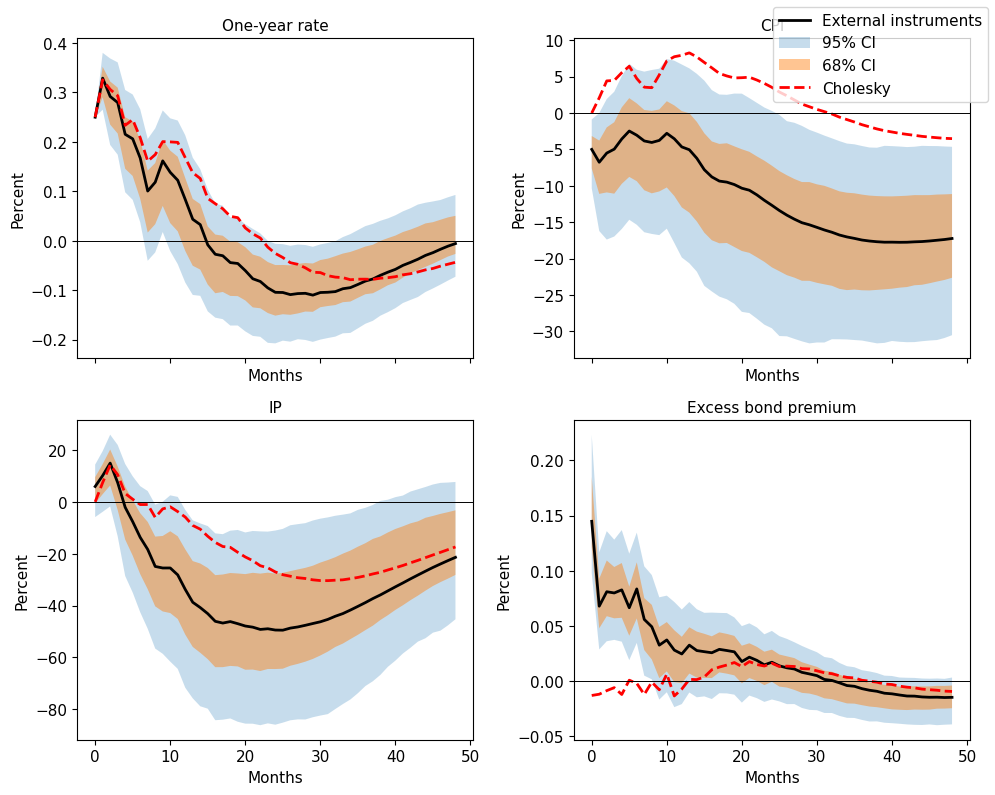

In [4]:
# VAR-level data
var_data = pd.read_csv("VAR_data.csv")
factor_data = pd.read_csv("factor_data.csv")

for df in (var_data, factor_data):
    df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
    df.set_index("date", inplace=True)

# GK sample
start, end = "1979-07-01", "2012-06-01"

# 4-variable VAR: IP, CPI, 1y rate, EBP
var_cols = ["logip", "logcpi", "gs1", "ebp"]
Y = var_data.loc[start:end, var_cols].copy()

# External instrument for baseline GK: monthly FF4 surprises
Z_ff4 = factor_data.loc[start:end, "ff4_tc"]

print("VAR sample:", Y.index[0], "to", Y.index[-1])
print("Number of observations:", len(Y))

# 1. Estimate reduced-form VAR

p = 12        # monthly VAR, 12 lags
irhor = 48    # IRF horizon in months

model = VAR(Y)
res = model.fit(p)
resid = res.resid

print(res.summary())


# 2. Some helper functions


def identify_proxy_svar(res, instrument_series, policy_var):
    """
    External-instrument identification of the monetary policy shock.

    res: statsmodels VARResults
    instrument_series: pd.Series with monthly instrument (same index as Y, or superset)
    policy_var: name of policy indicator in res.resid.columns (here: 'gs1')
    """
    resid = res.resid.copy()
    z = instrument_series.rename("z")

    # Align residuals and instrument in time and drop months without instrument
    data = resid.join(z, how="inner").dropna(subset=["z"])
    U = data[resid.columns].values
    Z = data["z"].values

    # Demean
    Z_dm = Z - Z.mean()
    U_dm = U - U.mean(axis=0)

    # Cross-covariance between reduced-form residuals and instrument
    cov_uz = (U_dm * Z_dm[:, None]).mean(axis=0)

    policy_idx = list(resid.columns).index(policy_var)
    # Normalise so impact on policy indicator residual is 1
    s = cov_uz / cov_uz[policy_idx]

    # First-stage regression diagnostics
    X = sm.add_constant(Z_dm)
    y = U_dm[:, policy_idx]
    ols_res = sm.OLS(y, X).fit()

    diag = {
        "policy_index": policy_idx,
        "impact_vector_s": s,
        "F": float(ols_res.fvalue),
        "pval_F": float(ols_res.f_pvalue),
        "beta": float(ols_res.params[1]),
        "t_beta": float(ols_res.tvalues[1]),
        "n_obs": len(Z_dm),
    }
    return s, diag


def irfs_from_var(res, s, horizon):
    """
    Compute IRFs to a structural shock with impact vector s
    using companion-form representation of the VAR.

    Returns array (horizon+1, nvars).
    """
    coefs = res.coefs         # shape (p, n, n)
    p, n, _ = coefs.shape
    k = n * p                 # size of companion state

    F = np.zeros((k, k))
    F[:n, :n*p] = np.hstack([coefs[i] for i in range(p)])
    if p > 1:
        F[n:, :-n] = np.eye(n*(p-1))

    G = np.zeros((k, n))
    G[:n, :] = np.eye(n)

    shock = np.asarray(s).reshape(n, 1)
    state = G @ shock

    irfs = np.zeros((horizon + 1, n))
    irfs[0, :] = state[:n, 0]
    for h in range(1, horizon + 1):
        state = F @ state
        irfs[h, :] = state[:n, 0]
    return irfs


def normalise_irfs_to_unit(irfs, policy_index):
    """
    Normalise IRFs so that the impact response of the policy variable equals 1.
    """
    factor = irfs[0, policy_index]
    return irfs / factor
def bootstrap_proxy_svar_unit(Y, instrument_series, policy_var,
                              p=12, horizon=48, nboot=1000, seed=123):
    """
    Wild bootstrap for proxy-SVAR.

    Returns boot_irfs: shape (nboot, horizon+1, nvars),
    where each draw is normalised to a unit policy shock
    (impact of policy variable = 1).
    """
    rng = np.random.default_rng(seed)

    base_res = VAR(Y).fit(p)
    resid = base_res.resid
    coefs = base_res.coefs
    const = base_res.intercept

    T = len(Y)
    n = Y.shape[1]
    index_Y = Y.index
    index_resid = resid.index

    policy_idx = list(Y.columns).index(policy_var)

    # Instrument aligned with residual index
    instr_resid = instrument_series.reindex(index_resid)

    boot_irfs = np.zeros((nboot, horizon + 1, n))

    for b in range(nboot):
        # Wild bootstrap: random ±1 multipliers
        signs = rng.choice([-1.0, 1.0], size=len(resid))
        res_boot = resid.values * signs[:, None]

        # Simulate new data path from VAR with bootstrapped residuals
        Y_boot = np.zeros((T, n))
        Y_boot[:p, :] = Y.values[:p, :]   # fix initial lags to actual data

        for t in range(p, T):
            y_pred = const.copy()
            for lag in range(p):
                y_pred += coefs[lag] @ Y_boot[t-1-lag, :]
            Y_boot[t, :] = y_pred + res_boot[t-p, :]

        Y_boot_df = pd.DataFrame(Y_boot, index=index_Y, columns=Y.columns)
        res_boot_est = VAR(Y_boot_df).fit(p)

        # Sign-flipped instrument for this draw
        instr_boot = instr_resid * signs

        s_b, _ = identify_proxy_svar(res_boot_est, instr_boot, policy_var)
        irfs_b_raw = irfs_from_var(res_boot_est, s_b, horizon)

        # Normalise to unit policy shock
        irfs_b_unit = irfs_b_raw / irfs_b_raw[0, policy_idx]
        boot_irfs[b, :, :] = irfs_b_unit

    return boot_irfs


def percentile_cis(boot_irfs, levels=(68, 95)):
    """
    Percentile confidence intervals from bootstrap draws.
    """
    boot = np.asarray(boot_irfs)
    cis = {}
    for level in levels:
        alpha = 1 - level / 100.0
        lower = np.quantile(boot, alpha / 2.0, axis=0)
        upper = np.quantile(boot, 1 - alpha / 2.0, axis=0)
        cis[level] = (lower, upper)
    return cis


def cholesky_irfs(res, policy_var, horizon):
    """
    Cholesky identification given the ordering in res.resid.columns.
    """
    resid = res.resid
    Sigma = resid.cov().values
    B = np.linalg.cholesky(Sigma)    # lower triangular

    policy_idx = list(resid.columns).index(policy_var)
    s_chol = B[:, policy_idx]

    irfs_chol_raw = irfs_from_var(res, s_chol, horizon)
    return irfs_chol_raw, s_chol



# 3. Baseline GK identification: external instrument and Cholesky


policy_var = "gs1"
gs1_idx = list(Y.columns).index(policy_var)

# External instrument identification
s_proxy, diag_proxy = identify_proxy_svar(res, Z_ff4, policy_var)
print("\nProxy-SVAR (FF4) first-stage F =", diag_proxy["F"])

irfs_proxy_raw = irfs_from_var(res, s_proxy, irhor)
irfs_proxy_unit = normalise_irfs_to_unit(irfs_proxy_raw, gs1_idx)

# Cholesky identification (ordering: IP, CPI, gs1, EBP)
irfs_chol_raw, s_chol = cholesky_irfs(res, policy_var, irhor)
irfs_chol_unit = normalise_irfs_to_unit(irfs_chol_raw, gs1_idx)

# Choose shock size: 0.25 percentage points (25 bp) on impact of 1-year rate
shock_size = 0.25
irfs_proxy = irfs_proxy_unit * shock_size
irfs_chol = irfs_chol_unit * shock_size


# 4. Wild bootstrap CIs for proxy-SVAR


nboot = 1000
print("\nBootstrapping proxy-SVAR with", nboot, "draws...")
boot_irfs_proxy_unit = bootstrap_proxy_svar_unit(
    Y, Z_ff4, policy_var, p=p, horizon=irhor, nboot=nboot, seed=123
)
boot_irfs_proxy = boot_irfs_proxy_unit * shock_size
cis_proxy = percentile_cis(boot_irfs_proxy, levels=(68, 95))


# 5. Plotting GK-style Figure 1: External instruments vs Cholesky


h = np.arange(irhor + 1)

cols = {name: i for i, name in enumerate(Y.columns)}
panel_vars   = ["gs1", "logcpi", "logip", "ebp"]
panel_titles = ["One-year rate", "CPI", "IP", "Excess bond premium"]

# log vars -> pct (approx), rates/spreads already in percent
scaling = {"gs1": 1.0, "ebp": 1.0, "logip": 100.0, "logcpi": 100.0}

lo68, hi68 = cis_proxy[68]
lo95, hi95 = cis_proxy[95]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.ravel()

for ax, var, title in zip(axes, panel_vars, panel_titles):
    j = cols[var]
    s = scaling[var]

    # Proxy-SVAR IRF
    ax.plot(h, s * irfs_proxy[:, j], lw=2, color="black", label="External instruments")

    # Bands (proxy-SVAR)
    ax.fill_between(h, s * lo95[:, j], s * hi95[:, j],
                    alpha=0.25, label="95% CI" if var == "gs1" else None)
    ax.fill_between(h, s * lo68[:, j], s * hi68[:, j],
                    alpha=0.45, label="68% CI" if var == "gs1" else None)

    # Cholesky IRF
    ax.plot(h, s * irfs_chol[:, j], lw=2, ls="--", color="red",
            label="Cholesky" if var == "gs1" else None)

    ax.axhline(0, lw=0.7, color="black")
    ax.set_title(title)
    ax.set_xlabel("Months")
    ax.set_ylabel("Percent")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.tight_layout()
plt.show()

In [5]:
s_proxy # impact vector

array([ 0.23704659, -0.19995323,  1.        ,  0.57931832])

**Comments:**

**1.2.** We have estimated 4-variable monthly VAR (IP, CPI, One-year rate, Excess bond premium) over 1979-2012 using the original data from GK article. FF4 was used as an external instrument for Proxy-SVAR identification. We computed IRFs for both External Intruments and Cholesky (confidence intervals were built only for External Intruments to combine graphs so that the differences between models would be more clear). For CPI and IP the scale waas normalized. ***As can be observed, graphs are almost identical to the original paper.***

**1.3.a.** First-stage F-statistic is **21.52** (close to the paper – it was 21.55) > 12 -> the instrument is relevant. By looking at the impact vector, we can estimate the effect of MP tightening (+25 bp in gs1) on each variable:

*   IP: +0.24 – output jumps immediately;
*   CPI: -0.20 – prices fall;
*   gs1: +1 – by construction;
*   EBP: +0.58 – immediate financial tightening (financial intermediaries become more risk‑averse and credit conditions tighten).

These findings confirm GR results: positive IP and negative CPI are standart for Proxy-SVAR models, high EBP validates that monetary policy shocks propagate not only through short-rate, but also via tightening of credit spreads and risk premia.

**1.3.b.** Ordering in Cholesky identification is crucial to determine how variables' shocks can affect each other. We determine this order: IP -> CPI -> one-year rate -> excess bond premium. Logic: real macro variables cannot immediately react on monetary shock (production changes for week/months, prices for weeks after shock), rate itself reacts immediately (by construction we change rate) and it affects financial market with some short lag. So for monetary shock for IP and CPI reaction in the period of the shock should be zero for Cholesky, and non-zero for External instrument (and it holds for our graphs: for IP and CPI red line (Cholesky) starts at zero, while black line (External Instruments) does not.
Comparing IRFs for Cholesky and Proxy-SVAR, we can see that graphs show similar patterns in responses (IP, CPI decline; EBP rises shortly and then decline), but Cholesky's responses are smaller in magnitude and more conservative. Proxy-SVAR model can be more preferable as it does not impose such strict restrictions on ordering, but can show sighnificant dynamic due to relevant instrument.

### 1.4. Plots for Scheduled vs Unscheduled vs all FOMC


--- Scheduled vs Unscheduled FOMC instruments ---
First-stage F (all)        = 0.8290670271714785
First-stage F (scheduled)  = 1.9969782792683608
First-stage F (unscheduled)= 12.06241534053459


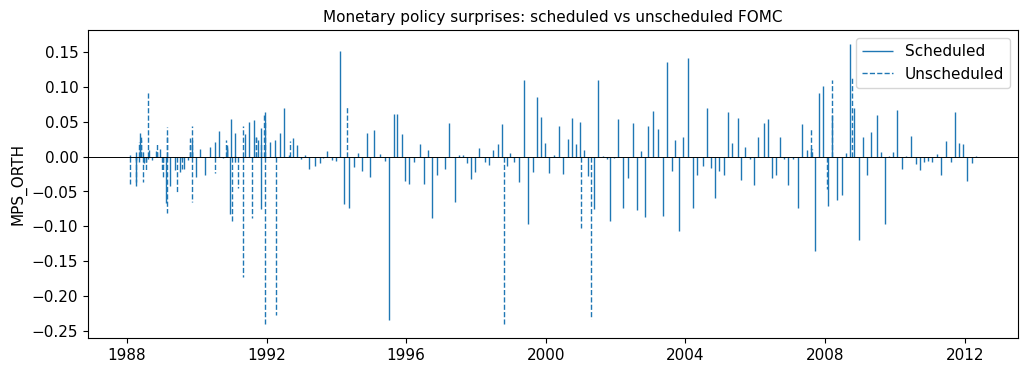

In [7]:
# Scheduled vs Unscheduled vs all FOMC instruments
print("\n--- Scheduled vs Unscheduled FOMC instruments ---")

xls = pd.ExcelFile("monetary-policy-surprises-data.xlsx")
fomc = pd.read_excel(xls, sheet_name="FOMC (update 2023)")

fomc["Date"] = pd.to_datetime(fomc["Date"])
fomc["ym"] = fomc["Date"].dt.to_period("M")
fomc["type"] = np.where(fomc["Unscheduled"] == 1, "unscheduled", "scheduled")
fomc["MPS_ORTH"] = pd.to_numeric(fomc["MPS_ORTH"], errors="coerce")


fomc_sub = fomc[(fomc["Date"] >= start) & (fomc["Date"] <= end)]

monthly_all = fomc_sub.groupby("ym")["MPS_ORTH"].sum().to_frame("MPS_all")
monthly_sched = (
    fomc_sub[fomc_sub["type"] == "scheduled"]
    .groupby("ym")["MPS_ORTH"].sum()
    .to_frame("MPS_sched")
)
monthly_unsched = (
    fomc_sub[fomc_sub["type"] == "unscheduled"]
    .groupby("ym")["MPS_ORTH"].sum()
    .to_frame("MPS_unsched")
)

monthly_instr = (
    monthly_all
    .join(monthly_sched, how="outer")
    .join(monthly_unsched, how="outer")
    .fillna(0.0)
)
monthly_instr.index = monthly_instr.index.to_timestamp(how="start")

Z_all     = monthly_instr["MPS_all"]
Z_sched   = monthly_instr["MPS_sched"]
Z_unsched = monthly_instr["MPS_unsched"]

# Proxy-SVAR identification (NO per-case normalisation here)
s_all,     diag_all     = identify_proxy_svar(res, Z_all,     policy_var)
s_sched,   diag_sched   = identify_proxy_svar(res, Z_sched,   policy_var)
s_unsched, diag_unsched = identify_proxy_svar(res, Z_unsched, policy_var)

print("First-stage F (all)        =", diag_all["F"])
print("First-stage F (scheduled)  =", diag_sched["F"])
print("First-stage F (unscheduled)=", diag_unsched["F"])

# IRFs to each structural shock, in the same (arbitrary) units
irfs_all_raw     = irfs_from_var(res, s_all,     irhor)
irfs_sched_raw   = irfs_from_var(res, s_sched,   irhor)
irfs_unsched_raw = irfs_from_var(res, s_unsched, irhor)

gs1_idx = list(Y.columns).index("gs1")
shock_size = 0.25    # 25bp

# scale so that UNSCHEDULED has a 25bp impact on gs1 at h=0
scale_factor = shock_size / irfs_unsched_raw[0, gs1_idx]

irfs_unsched = irfs_unsched_raw
irfs_all     = irfs_all_raw
irfs_sched   = irfs_sched_raw


# Event plot of scheduled vs unscheduled surprises

fig, ax = plt.subplots(figsize=(12, 4))
sched = fomc_sub[fomc_sub["type"] == "scheduled"]
unsched = fomc_sub[fomc_sub["type"] == "unscheduled"]

ax.vlines(sched["Date"], 0, sched["MPS_ORTH"], linewidth=1, label="Scheduled")
ax.vlines(
    unsched["Date"],
    0,
    unsched["MPS_ORTH"],
    linewidth=1,
    linestyles="dashed",
    label="Unscheduled",
)
ax.axhline(0, lw=0.7, color="black")
ax.set_ylabel("MPS_ORTH")
ax.set_title("Monetary policy surprises: scheduled vs unscheduled FOMC")
ax.legend()
plt.show()

**Comment:** by looking at the graph, we can see that scheduled FOMC meetings occur more frequently, but the magnitude of monetary surprises (MPS_ORTH) varies significantly across events. Unscheduled meetings are rarer, yet they tend to generate larger impacts (taller bars), particularly for negative surprises corresponding to monetary policy easing.

This pattern aligns with F-statistic: only for Unscheduled event F-stat = 12.06 > 12 -> stronger instrument that we should use in our analysis. These results are consistent with theory as unscheduled FOCM meetings can generate larger monetary surprises due to lower information leakage before meeting.

### 1.5. Replicating Figure 1, but using Sceduled and Unsceduled FOMC meetings

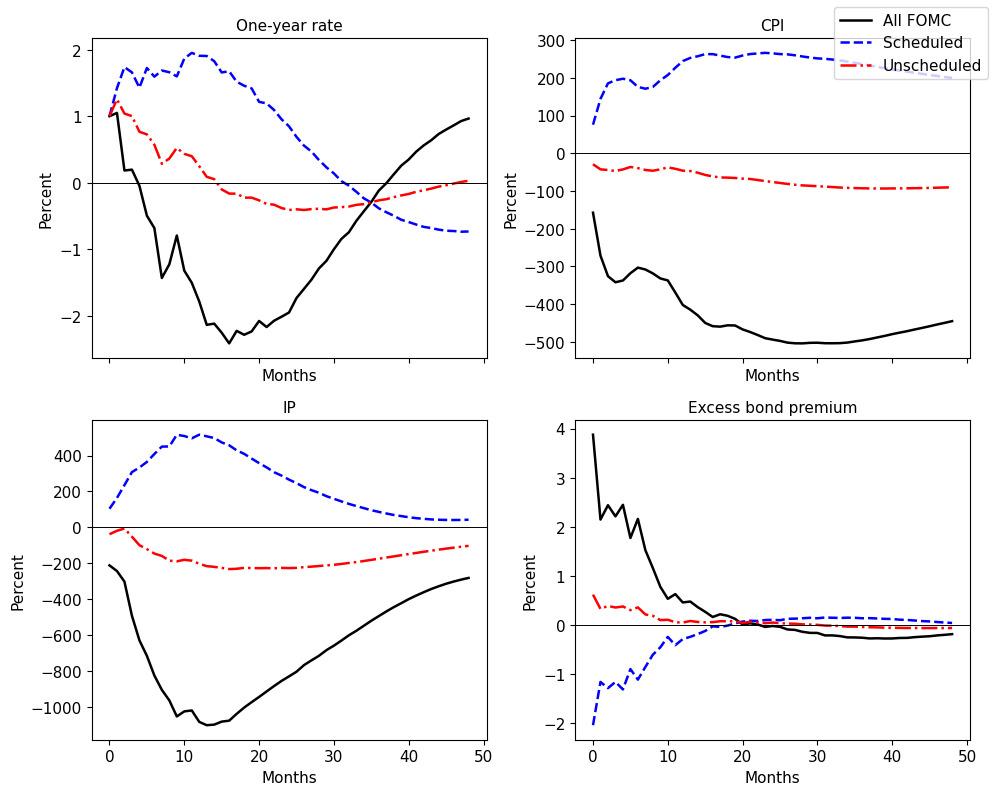

In [8]:
# IRFs: all vs scheduled vs unscheduled FOMC instruments
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.ravel()

for ax, var, title in zip(axes, panel_vars, panel_titles):
    j = cols[var]
    s = scaling[var]

    ax.plot(h, s * irfs_all[:, j],     lw=1.8, color="black", label="All FOMC")
    ax.plot(h, s * irfs_sched[:, j],   lw=1.8, ls="--", color="blue",
            label="Scheduled")
    ax.plot(h, s * irfs_unsched[:, j], lw=1.8, ls="-.", color="red",
            label="Unscheduled")

    ax.axhline(0, lw=0.7, color="black")
    ax.set_title(title)
    ax.set_xlabel("Months")
    ax.set_ylabel("Percent")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.tight_layout()
plt.show()

**Comment:** in this part we were trying to replicate external instruments from 1.2 with FOMC meetings and monetary surprises. We can notice that all FOMC were closer to external instrument (it looks like lower bound of 95% CI), despite lower F-statistic. Unscheduled meetings show similar dynamic to all meetings, but produce milder IRFs. We can explain it in this way – when meeting is unscheduled, it is usually a reaction on a crisis in economics -> some information might be already priced-in by markets. With scheduled meetings show opposite-signed responses confirming its unsuitability as an instrument (with scheduled meeting market can guess decision in advance). Despite weaker magnitude, unscheduled meetings are still the preferred instruments due to higher first-stage F-stat.   